# Tutorial: Separator Unit Model with Modular Property Package

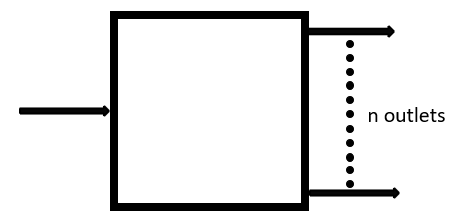

In [87]:
from IPython.core.display import Image
Image(filename='separator.PNG')

## Learning Outcomes

- Demonstrate use of the separator unit model in IDAES
- Demonstrate different separation options available


## Problem Statement

In this example, we will be separating a feed stream of liquid H2O and CO2 vapor. The inlet conditions are as follows:

**Inlet:**

Flow Rate = 100 mol/s

Mole Fraction (H2O) = 0.9

Mole Fraction (CO2) = 0.1

Temperature = 298 K

Pressure = 101325 Pa

We will look at three cases in this tutorial:

Case 1: Separate on a total flow split basis

Case 2: Separate on a phase flow split basis

Case 3: Separate on a component flow split basis


For more details, please refer to the IDAES documentation: https://idaes-pse.readthedocs.io/en/stable

## Setting up the problem in IDAES

In the following cell, we will be importing the necessary components from Pyomo and IDAES.

In [88]:
# Import objects from pyomo package 
from pyomo.environ import ConcreteModel, value

# Import the solver
from idaes.core.solvers import get_solver

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import the option to set the type of material balance 
from idaes.core import MaterialBalanceType

# Import the separator unit model
from idaes.models.unit_models import Separator

# Import the option to set the basis for splitting
from idaes.models.unit_models.separator import SplittingType

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the modular property package to create a property block for the flowsheet
from idaes.models.properties.modular_properties.base.generic_property import GenericParameterBlock

# Import the BT_Ideal property package to create a configuration file for the GenericParameterBlock
from idaes.models.properties.modular_properties.examples.CO2_H2O_Ideal_VLE import configuration

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Create the ConcreteModel and the FlowsheetBlock objects, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(dynamic=False) # dynamic or ss flowsheet needs to be specified here

# Add properties parameter block to the flowsheet with the appropriate configuration file
m.fs.properties = GenericParameterBlock(**configuration)



## Case 1:

In the following cell, we will be creating the separator unit model that splits on a *total flow basis* and determining the degrees of freedom associated with this separator unit model.

In [89]:
# Create an instance of the separator unit, attaching it to the flowsheet
# Specify that the property package to be used with the separator is the one we created earlier

m.fs.sep_1 = Separator(
    property_package=m.fs.properties,
    split_basis=SplittingType.totalFlow,
    outlet_list=["a1", "b1", "c1"],  # creates three outlet streams
    ideal_separation=False,
    has_phase_equilibrium=False,
)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom are: {0}'.format(DOF_initial))

2022-12-01 08:41:16 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_1.mixed_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:16 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_1.a1_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:16 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_1.b1_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:16 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_1.c1_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
The i

In [90]:
assert DOF_initial == 7

In the following cell, we will be specifying the inlet conditions for the separator block and ensuring that there are zero degrees of freedom.

In [91]:
# Fix the inlet conditions

# Inlet stream
m.fs.sep_1.inlet.flow_mol.fix(10) # converting to mol/s as unit basis is mol/s
m.fs.sep_1.inlet.mole_frac_comp[0, "H2O"].fix(0.9)
m.fs.sep_1.inlet.mole_frac_comp[0, "CO2"].fix(0.1)
m.fs.sep_1.inlet.pressure.fix(101325) # Pa
m.fs.sep_1.inlet.temperature.fix(353) # K

# Separator unit variables
m.fs.sep_1.split_fraction[0, "a1"].fix(0.2)
m.fs.sep_1.split_fraction[0, "b1"].fix(0.5)
# Directly setting the split fraction of c will cause the DOF check to fail

# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

The final degrees of freedom is: 0


In [92]:
assert DOF_final == 0

### Flowsheet Initialization

In [93]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.sep_1.initialize(outlvl=idaeslog.WARNING)

### Obtaining Simulation Results

In [94]:
# Solve the simulation using the IDAES solver
# Note: If the degrees of freedom = 0, we have a square problem
solver = get_solver()
result = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

In [95]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

As expected the three outlet streams share the same composition as the inlet stream with the only difference being their molar flowrate, which was determined by their respective split fractions.

In [96]:
# Display output report
m.fs.sep_1.report()


Unit : fs.sep_1                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                      : Value   : Units         : Fixed : Bounds
    Split Fraction [('a1',)] : 0.20000 : dimensionless :  True : (None, None)
    Split Fraction [('b1',)] : 0.50000 : dimensionless :  True : (None, None)
    Split Fraction [('c1',)] : 0.30000 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                Units         Inlet       a1         b1         c1    
    Total Molar Flowrate     mole / second     10.000     2.0000     5.0000     3.0000
    Total Mole Fraction H2O  dimensionless    0.90000    0.90000    0.90000    0.90000
    Total Mole Fraction CO2  dimensionless    0.10000    0.10000    0.10000    0.10000
    Temperature                  

In [97]:
import pytest

# Check outlet a results
assert value(m.fs.sep_1.a1.flow_mol[0]) == pytest.approx(2, rel=1e-6)
assert value(m.fs.sep_1.a1.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_1.a1.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_1.a1.mole_frac_comp[0,"H2O"]) == pytest.approx(0.9, rel=1e-6)
assert value(m.fs.sep_1.a1.mole_frac_comp[0,"CO2"]) == pytest.approx(0.1, rel=1e-6)


# Check outlet b results
assert value(m.fs.sep_1.b1.flow_mol[0]) == pytest.approx(5, rel=1e-6)
assert value(m.fs.sep_1.b1.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_1.b1.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_1.b1.mole_frac_comp[0,"H2O"]) == pytest.approx(0.9, rel=1e-6)
assert value(m.fs.sep_1.b1.mole_frac_comp[0,"CO2"]) == pytest.approx(0.1, rel=1e-6)

# Check outlet c results
assert value(m.fs.sep_1.c1.flow_mol[0]) == pytest.approx(3, rel=1e-6)
assert value(m.fs.sep_1.c1.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_1.c1.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_1.c1.mole_frac_comp[0,"H2O"]) == pytest.approx(0.9, rel=1e-6)
assert value(m.fs.sep_1.c1.mole_frac_comp[0,"CO2"]) == pytest.approx(0.1, rel=1e-6)


## Case 2:

In the following cell, we will be creating the separator unit model that splits on a *phase flow basis* and determining the degrees of freedom associated with this separator unit model.

In [98]:
# Create an instance of the separator unit, attaching it to the flowsheet
# Specify that the property package to be used with the separator is the one we created earlier

m.fs.sep_2 = Separator(
    property_package=m.fs.properties,
    split_basis=SplittingType.phaseFlow,
    outlet_list=["a2", "b2"],
    ideal_separation=False,
    has_phase_equilibrium=False,
)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom are: {0}'.format(DOF_initial))

2022-12-01 08:41:18 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_2.mixed_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:18 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_2.a2_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:18 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_2.b2_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
The initial degrees of freedom are: 7


In [99]:
assert DOF_initial == 7

In the following cell, we will be specifying the inlet conditions for the separator block and ensuring that there are zero degrees of freedom.

In [100]:
# Fix the inlet conditions

# Inlet stream
m.fs.sep_2.inlet.flow_mol.fix(10) # converting to mol/s as unit basis is mol/s
m.fs.sep_2.inlet.mole_frac_comp[0, "H2O"].fix(0.9)
m.fs.sep_2.inlet.mole_frac_comp[0, "CO2"].fix(0.1)
m.fs.sep_2.inlet.pressure.fix(101325) # Pa
m.fs.sep_2.inlet.temperature.fix(353) # K

# Separator unit variables
m.fs.sep_2.split_fraction[0, "a2", "Vap"].fix(0.8)
m.fs.sep_2.split_fraction[0, "b2", "Liq"].fix(0.8)

# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

The final degrees of freedom is: 0


In [101]:
assert DOF_final == 0

### Flowsheet Initialization

In [102]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.sep_2.initialize(outlvl=idaeslog.WARNING)

### Obtaining Simulation Results

In [103]:
# Solve the simulation using the IDAES solver
# Note: If the degrees of freedom = 0, we have a square problem
solver = get_solver()
result = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

In [104]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

In [105]:
# Display output report
m.fs.sep_2.report()


Unit : fs.sep_2                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                            : Value   : Units         : Fixed : Bounds
    Split Fraction [('a2', 'Liq')] : 0.20000 : dimensionless : False : (None, None)
    Split Fraction [('a2', 'Vap')] : 0.80000 : dimensionless :  True : (None, None)
    Split Fraction [('b2', 'Liq')] : 0.80000 : dimensionless :  True : (None, None)
    Split Fraction [('b2', 'Vap')] : 0.20000 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                Units         Inlet       a2         b2    
    Total Molar Flowrate     mole / second     10.000     3.1220     6.8780
    Total Mole Fraction H2O  dimensionless    0.90000    0.74375    0.97092
    Total Mole Fraction CO2  dimensionless   

In [106]:
import pytest

# Check outlet a results
assert value(m.fs.sep_2.a2.flow_mol[0]) == pytest.approx(3.1220, rel=1e-3)
assert value(m.fs.sep_2.a2.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_2.a2.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_2.a2.mole_frac_comp[0,"H2O"]) == pytest.approx(0.74375, rel=1e-5)
assert value(m.fs.sep_2.a2.mole_frac_comp[0,"CO2"]) == pytest.approx(0.25625, rel=1e-5)


# Check outlet b results
assert value(m.fs.sep_2.b2.flow_mol[0]) == pytest.approx(6.878, rel=1e-3)
assert value(m.fs.sep_2.b2.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_2.b2.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_2.b2.mole_frac_comp[0,"H2O"]) == pytest.approx(0.97092, rel=1e-5)
assert value(m.fs.sep_2.b2.mole_frac_comp[0,"CO2"]) == pytest.approx(0.029078, rel=1e-5)


## Case 3:

In the following cell, we will be creating the separator unit model that splits on a *component flow basis* and determining the degrees of freedom associated with this separator unit model.

In [107]:
# Create an instance of the separator unit, attaching it to the flowsheet
# Specify that the property package to be used with the separator is the one we created earlier

m.fs.sep_3 = Separator(
    property_package=m.fs.properties,
    split_basis=SplittingType.componentFlow,
    outlet_list=["a3", "b3", "c3", "d3"],
    ideal_separation=False,
    has_phase_equilibrium=False,
)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom are: {0}'.format(DOF_initial))

2022-12-01 08:41:19 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_3.mixed_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:19 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_3.a3_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:19 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_3.b3_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-12-01 08:41:19 [WARNING] idaes.models.properties.modular_properties.state_definitions.FTPx: fs.sep_3.c3_state[0.0] - found state_bounds argument for mole_frac_comp. Mole fraction bounds are set automatically and this argument will be ignored.
2022-

In [108]:
assert DOF_initial == 11

In the following cell, we will be specifying the inlet conditions for the separator block and ensuring that there are zero degrees of freedom.

In [109]:
# Fix the inlet conditions

# Inlet stream
m.fs.sep_3.inlet.flow_mol.fix(10) # converting to mol/s as unit basis is mol/s
m.fs.sep_3.inlet.mole_frac_comp[0, "H2O"].fix(0.9)
m.fs.sep_3.inlet.mole_frac_comp[0, "CO2"].fix(0.1)
m.fs.sep_3.inlet.pressure.fix(101325) # Pa
m.fs.sep_3.inlet.temperature.fix(353) # K

# Separator unit variables
m.fs.sep_3.split_fraction[0, "a3", "H2O"].fix(0.25)
m.fs.sep_3.split_fraction[0, "b3", "H2O"].fix(0.5)
m.fs.sep_3.split_fraction[0, "c3", "H2O"].fix(0.1)

m.fs.sep_3.split_fraction[0, "a3", "CO2"].fix(0.1)
m.fs.sep_3.split_fraction[0, "b3", "CO2"].fix(0.2)
m.fs.sep_3.split_fraction[0, "c3", "CO2"].fix(0.3)

# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

The final degrees of freedom is: 0


In [110]:
assert DOF_final == 0

### Flowsheet Initialization

In [111]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.sep_3.initialize(outlvl=idaeslog.WARNING)

### Obtaining Simulation Results

In [112]:
# Solve the simulation using the IDAES solver
# Note: If the degrees of freedom = 0, we have a square problem
solver = get_solver()
result = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

In [113]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

In [114]:
# Display output report
m.fs.sep_3.report()


Unit : fs.sep_3                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                            : Value   : Units         : Fixed : Bounds
    Split Fraction [('a3', 'CO2')] : 0.10000 : dimensionless :  True : (None, None)
    Split Fraction [('a3', 'H2O')] : 0.25000 : dimensionless :  True : (None, None)
    Split Fraction [('b3', 'CO2')] : 0.20000 : dimensionless :  True : (None, None)
    Split Fraction [('b3', 'H2O')] : 0.50000 : dimensionless :  True : (None, None)
    Split Fraction [('c3', 'CO2')] : 0.30000 : dimensionless :  True : (None, None)
    Split Fraction [('c3', 'H2O')] : 0.10000 : dimensionless :  True : (None, None)
    Split Fraction [('d3', 'CO2')] : 0.40000 : dimensionless : False : (None, None)
    Split Fraction [('d3', 'H2O')] : 0.15000 : dimensionless : False : (None, None)

---------------------------------------

In [115]:
import pytest

# Check outlet a results
assert value(m.fs.sep_3.a3.flow_mol[0]) == pytest.approx(2.35, rel=1e-3)
assert value(m.fs.sep_3.a3.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_3.a3.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_3.a3.mole_frac_comp[0,"H2O"]) == pytest.approx(0.95745, rel=1e-5)
assert value(m.fs.sep_3.a3.mole_frac_comp[0,"CO2"]) == pytest.approx(0.042553, rel=1e-5)

# Check outlet b results
assert value(m.fs.sep_3.b3.flow_mol[0]) == pytest.approx(4.7, rel=1e-3)
assert value(m.fs.sep_3.b3.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_3.b3.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_3.b3.mole_frac_comp[0,"H2O"]) == pytest.approx(0.95745, rel=1e-5)
assert value(m.fs.sep_3.b3.mole_frac_comp[0,"CO2"]) == pytest.approx(0.042553, rel=1e-5)

# Check outlet c results
assert value(m.fs.sep_3.c3.flow_mol[0]) == pytest.approx(1.2, rel=1e-3)
assert value(m.fs.sep_3.c3.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_3.c3.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_3.c3.mole_frac_comp[0,"H2O"]) == pytest.approx(0.75, rel=1e-5)
assert value(m.fs.sep_3.c3.mole_frac_comp[0,"CO2"]) == pytest.approx(0.25, rel=1e-5)

# Check outlet d results
assert value(m.fs.sep_3.d3.flow_mol[0]) == pytest.approx(1.75, rel=1e-3)
assert value(m.fs.sep_3.d3.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.sep_3.d3.temperature[0]) == pytest.approx(353, rel=1e-6)
assert value(m.fs.sep_3.d3.mole_frac_comp[0,"H2O"]) == pytest.approx(0.77143, rel=1e-5)
assert value(m.fs.sep_3.d3.mole_frac_comp[0,"CO2"]) == pytest.approx(0.22857, rel=1e-5)